<a href="https://colab.research.google.com/github/juliachoww/FOMCtopicmodelling/blob/main/Fed_IR_TopicModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The dataset used for topic modelling comprises 121 past FOMC Statements across 15 years from 2009 to 2024. This date range was used as the first year that the format of FOMC minutes started becoming similar to the latest format was in 2009.

The FOMC statements were obtained via web scraping using Fedtools, an open source python library: https://github.com/David-Woroniuk/FedTools

General sequence:

*   The corpus of FOMC minutes was first decomposed to only include the "staff economic outlook" section of each document using regex
*   then pre-processed and tokenized using the NLTK library
*   vectorization using TF-IDF is then performed
*   and finally LDA from the scikit library is used to extract the topics

The top 3 topics from each document based on document topic probability are highlighted in a pandas dataframe to give a high level view on what economic phenomena Fed board members are focused on at each meeting.

For instance, topic 16 is about the covid outbreak which is flagged out as a high probability topic in most 2020 meeting minutes.

In [ ]:
pip install FedTools

In [ ]:
pip install NLTK

In [92]:
#Import Relevant Packages
import re
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
from collections import Counter
import requests
import os
import numpy as np
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
#Import the FOMC Minutes
from FedTools import FederalReserveMins

fed_mins = FederalReserveMins(
            main_url = 'https://www.federalreserve.gov',
            calendar_url ='https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm',
            start_year = 2009,
            historical_split = 2018,
            verbose = True,
            thread_num = 10)

dataset = fed_mins.find_minutes()
dataset = dataset.reset_index()

Constructing links between 2009 and 2024
Extracting Federal Reserve Minutes.
Retrieving articles.
.........................................................................................................................

In [6]:
#Check the number of documents loaded
dataset.shape[0]

121

In [7]:
#Dataset to only include a column with statement and a column with date of statement
dataset['Date'] = pd.to_datetime(dataset['index'])
dataset = dataset.drop(['index'], axis=1)

In [8]:
#Only extract necessary part of minutes
start_regex = r"""(?i)(staff\s+economic\s+outlook)"""
end_regex = r"""(?i)(meeting\s+participants['"]\s+views\s+and\s+committee\s+policy\s+action|participants['"]\s+views?\s+(?:(on\s+|of\s+)(?:|the\s+)current\s+(?:|economic\s+)conditions\s+and\s+(?:|the\s+)economic\s+outlook|and\s+committee\s+policy\s+action))"""

def truncate_text(text, start_regex, end_regex):
    start_match = re.search(start_regex, text)
    end_match = re.search(end_regex, text)
    if start_match and end_match:
        start_index = start_match.start()
        end_index = end_match.end()
        return text[start_index:end_match.start()]
    else:
        return text

# Apply truncation to each row in the DataFrame
dataset['Truncated_Text'] = dataset['Federal_Reserve_Mins'].apply(lambda x: truncate_text(x, start_regex, end_regex))

# Display the DataFrame with truncated text
dataset[['Truncated_Text']][51:54]

,Truncated_Text
51,Staff Economic Outlook In the economic foreca...
52,Staff Economic Outlook The U.S. economic fore...
53,Staff Economic Outlook The U.S. economic fore...


In [9]:
#Check that the regex works on all documents otherwise flag out the document
count = 0
date_nomatch_list = []
for i in range(len(dataset)):
  if re.search(r"""^Staff""", dataset['Truncated_Text'][i]):
    count += 1
  else:
    date_nomatch_list.append(dataset['Date'][i])
print(count)
date_nomatch_list

121


[]

In [10]:
# #Clean FOMC text

# #Convert all statements to lower case
dataset['Modified'] = dataset['Truncated_Text'].str.lower()

#Remove punctuation and stopwords
stopwords_set = set(stopwords.words('english'))
punctuation_set = set(string.punctuation) | {'--', '-', '."', ',"', '.)', ')-', '".', '—', '),'}
punctuation_stopwords = stopwords_set.union(punctuation_set)

def remove_punctuation_stopwords(text):
    return ' '.join(''.join(char for char in word if char.isalnum())
                    for word in text.split()
                    if word.lower() not in punctuation_stopwords)

dataset['Modified'] = dataset['Modified'].apply(remove_punctuation_stopwords)

#Stem words
ps = nltk.PorterStemmer()
def stem_text(text):
    return ' '.join(ps.stem(term) for term in text.split())
dataset['Modified'] = dataset['Modified'].apply(stem_text)

In [17]:
modified_list = dataset['Modified'].apply(lambda x: x.split())
all_words = [word for sublist in modified_list for word in sublist] # list of all the words in your corpus
fdist = FreqDist(all_words) # a frequency distribution of words (word count over the corpus)
k = 10 # say you want to see the top 10 words
top_k_words, _ = zip(*fdist.most_common(k)) # unzip the words and word count tuples
print(top_k_words)

#Exclude top 10 words to improve topic quality later
words_modified = []
for i in all_words:
  if i not in top_k_words:
    words_modified.append(i)

('staff', 'project', 'inflat', 'forecast', 'expect', 'year', 'real', 'gdp', 'growth', 'rate')


In [36]:
#Tokenize
from nltk.tokenize import word_tokenize

def tokenize_text(text):
    return word_tokenize(text)

all_tokens_flat = [token for sublist in all_tokens for token in sublist]

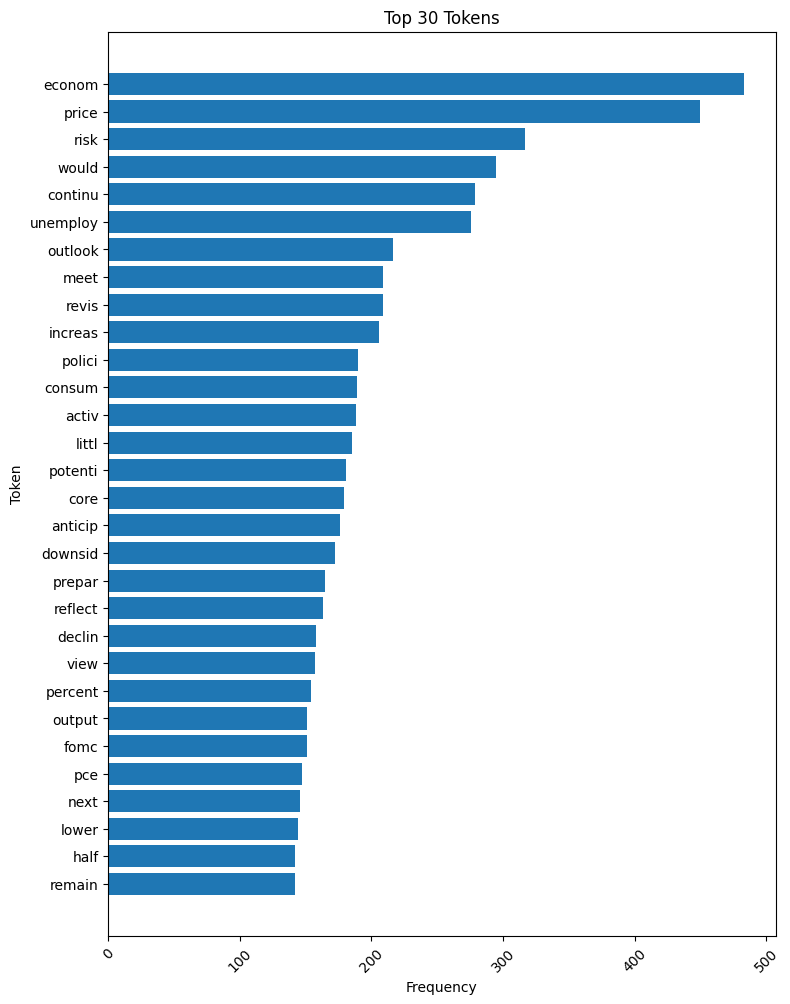

In [38]:
#Visualize top 30 occuring tokens across all documents
# Count the occurrences of each token
token_counts = Counter(all_tokens_flat)

# Get the top 30 tokens and their frequencies
top_30_tokens = token_counts.most_common(30)

# Reverse the list so that the most frequent tokens are at the top
top_30_tokens = top_30_tokens[::-1]

# Extract tokens and frequencies
tokens, frequencies = zip(*top_30_tokens)

# Create the bar plot
plt.figure(figsize=(8, 10))  # Adjust the figure size as needed
plt.barh(range(len(tokens)), frequencies, align='center')
plt.yticks(range(len(tokens)), tokens)  # Use tokens as y-axis labels
plt.xlabel('Frequency')
plt.ylabel('Token')
plt.title('Top 30 Tokens')
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()

In [51]:
# Define a set of words to exclude
words_to_exclude = {'staff', 'project', 'inflat', 'forecast', 'expect', 'year', 'real', 'gdp', 'growth', 'rate'}

# Define a tokenization function with exclusion
def tokenize_text_exclude(text):
    tokens = word_tokenize(text)  # Tokenize the text
    filtered_tokens = [token for token in tokens if token.lower() not in words_to_exclude]  # Filter out excluded words
    return filtered_tokens

# Apply the tokenization function to the 'Modified' column and store the filtered tokens in a new column 'Tokens'
dataset['Tokens'] = dataset['Modified'].apply(tokenize_text_exclude)

# Extract documents from the "Tokens" column
document_list = dataset['Tokens'].astype(str).tolist()

# Vectorize documents using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english',
                             use_idf=True,
                             smooth_idf=True)

# Fit and transform documents to get TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(document_list)

# Define the number of topics or components
num_components = 20

# Create LDA object
lda_model = LatentDirichletAllocation(n_components=num_components)

# Fit LDA model on SVD-transformed data
lda_matrix = lda_model.fit_transform(tfidf_matrix)

# Get Components
lda_components = lda_model.components_

# Get the feature names
terms = vectorizer.get_feature_names_out()

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key = sorted(zipped, key=lambda t: t[1], reverse=True)[:7]
    top_terms_list = [term for term, _ in top_terms_key]
    print("Topic " + str(index+1) + ": ", top_terms_list)

Topic 1:  ['categori', 'volatil', 'cpi', 'judgment', '25', 'defens', 'shallow']
Topic 2:  ['global', 'productmarket', 'slight', 'greaterthanassum', 'resurg', 'socialdistanc', 'requir']
Topic 3:  ['secur', 'lessfavor', 'movement', 'headlin', 'countri', 'difficulti', 'predict']
Topic 4:  ['novemb', 'good', 'legisl', 'accordingli', 'check', 'heighten', 'undertak']
Topic 5:  ['econom', 'price', 'risk', 'unemploy', 'continu', 'core', 'littl']
Topic 6:  ['2014', 'eventu', 'trend', 'sep', 'summari', 'octob', 'construct']
Topic 7:  ['issu', 'caus', 'therefor', 'post', 'reopen', 'revers', 'sizabl']
Topic 8:  ['headlin', 'purchas', '2014', 'repres', 'temporarili', 'disast', 'japan']
Topic 9:  ['2011', '2010', 'recoveri', 'posit', 'tilt', 'demand', '2009']
Topic 10:  ['withstand', '2014', 'export', 'stanc', 'extent', 'help', 'octob']
Topic 11:  ['probabl', 'surg', 'unwind', 'cours', 'contrast', 'supplyrel', 'therebi']
Topic 12:  ['turnaround', 'purchas', 'sizabl', 'lesser', 'degre', 'privat', 'fi

In [109]:
document_dates = dataset['Date'].tolist()
topic_names = []

for i in range(num_components):
  topic_names.append('Topic:'+str(i+1))

# Create a DataFrame to store the document-topic matrix
df = pd.DataFrame(lda_matrix, index=document_dates, columns=topic_names)

# Add a column to the DataFrame containing the document-topic matrix
def highlight_top_5(row):
    is_top_5 = row.isin(row.nlargest(3))  # Check if value is in the top 5 for the row
    return ['background-color: yellow' if v else '' for v in is_top_5]

# Apply the highlight function to the DataFrame along axis=1 (rows)
styled_df = df.style.apply(highlight_top_5, axis=1)
styled_df

,Topic:1,Topic:2,Topic:3,Topic:4,Topic:5,Topic:6,Topic:7,Topic:8,Topic:9,Topic:10,Topic:11,Topic:12,Topic:13,Topic:14,Topic:15,Topic:16,Topic:17,Topic:18,Topic:19,Topic:20
2009-01-28 00:00:00,0.005550,0.005550,0.005550,0.005550,0.459408,0.005550,0.005550,0.005550,0.257007,0.005550,0.005550,0.005550,0.005550,0.005550,0.189239,0.005550,0.005550,0.005550,0.005550,0.005550
2009-03-18 00:00:00,0.004267,0.004267,0.004267,0.004267,0.388256,0.004267,0.004267,0.004267,0.175026,0.047599,0.004267,0.004267,0.004267,0.036183,0.079099,0.004267,0.004267,0.004267,0.214101,0.004267
2009-04-29 00:00:00,0.004436,0.004436,0.004436,0.004436,0.447422,0.004436,0.004436,0.004436,0.198813,0.004436,0.004436,0.004436,0.004436,0.004436,0.278350,0.004436,0.004436,0.004436,0.004436,0.004436
2009-06-24 00:00:00,0.004609,0.004609,0.102759,0.004609,0.425906,0.004609,0.004609,0.004609,0.259579,0.004609,0.004609,0.004609,0.004609,0.004609,0.138015,0.004609,0.004609,0.004609,0.004609,0.004609
2009-08-12 00:00:00,0.004648,0.004648,0.004648,0.004648,0.456685,0.004648,0.004648,0.004648,0.459644,0.004648,0.004648,0.004648,0.004648,0.004648,0.004648,0.004648,0.004648,0.004648,0.004648,0.004648
2009-09-23 00:00:00,0.004556,0.004556,0.004556,0.004556,0.441610,0.004556,0.004556,0.004556,0.476379,0.004556,0.004556,0.004556,0.004556,0.004556,0.004556,0.004556,0.004556,0.004556,0.004556,0.004556
2009-11-04 00:00:00,0.005069,0.005069,0.005069,0.005069,0.544200,0.005069,0.005069,0.005069,0.219365,0.005069,0.005069,0.005069,0.150261,0.005069,0.005069,0.005069,0.005069,0.005069,0.005069,0.005069
2009-12-16 00:00:00,0.005101,0.005101,0.005101,0.005101,0.517248,0.005101,0.005101,0.016003,0.237299,0.005101,0.005101,0.005101,0.015314,0.005101,0.005101,0.137628,0.005101,0.005101,0.005101,0.005101
2010-01-27 00:00:00,0.005101,0.005101,0.005101,0.005101,0.488233,0.005101,0.005101,0.005101,0.169335,0.068304,0.005101,0.005101,0.005101,0.005101,0.005101,0.005101,0.005101,0.192520,0.005101,0.005101
2010-03-16 00:00:00,0.005230,0.005230,0.005230,0.005230,0.507706,0.005230,0.005230,0.005230,0.136602,0.266778,0.005230,0.005230,0.005230,0.005230,0.005230,0.005230,0.005230,0.005230,0.005230,0.005230
